The linear regression model discussed in Chapter 3 assumes the response variable $Y$ is quantititative. But in many situations, the response variable is instead *qualitative* (a.k.a. *categorical*). For example, eye color is qualitative, taking on values of blue, brown, or green. Predicting a qualitative response is known as *classification*. Predicting a qualitative response for an observation to a category or class can be referred to as *classifying* since it involves assigning the observation to a category, or class. The methods used for classification first predict the probability of each of the categories of a qualitative variable, which in a sense also behaves like linear regression.  

In this chapter we will discuss three of the most widely-used classifiers: *logistic regression*, *linear discriminant analysis*, and *K-nearest neighbors*.  

# An Overview of Classification
Some examples of classification include:  
1. A person arrives at the emergency room with a set of symptoms that could be attributed to one of three medical conditions. Which condition does the patient actually have?  
2. An online banking service must be able to determine whether or not a transaction is fraudulent on the basis of the user's IP address, past transaction history, and so forth.  
3. On the basis of DNA sequence data for a number of patients without a given disease, a biologist would like to figure out which DNA mutations are deleterious (disease-causing) and which are not.  

As in th regression setting, we have a set of training observations $(x_1, y_1), ..., (x_n, y_n)$ that we can use to build a classifier. We want our classifier to perform well not only on the training data, but unseen test data as well. We will be using the **Default** data set to predict whether an individual will default ($Y$) on their credit card payment on the basis of monthly credit card balance ($X_1$) and income ($X_2$). *Note: there is a very pronounced relationship between the predictors and the response, while in most real world applications, the relationship will not be nearly as strong*. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [63]:
default = pd.read_csv('../../data/Default.csv', index_col=0)
print('{}\n\n'.format(default.describe()))
print(default.describe(include=['O']))

            balance        income
count  10000.000000  10000.000000
mean     835.374886  33516.981876
std      483.714985  13336.639563
min        0.000000    771.967729
25%      481.731105  21340.462905
50%      823.636973  34552.644800
75%     1166.308387  43807.729275
max     2654.322576  73554.233500


       default student
count    10000   10000
unique       2       2
top         No      No
freq      9667    7056


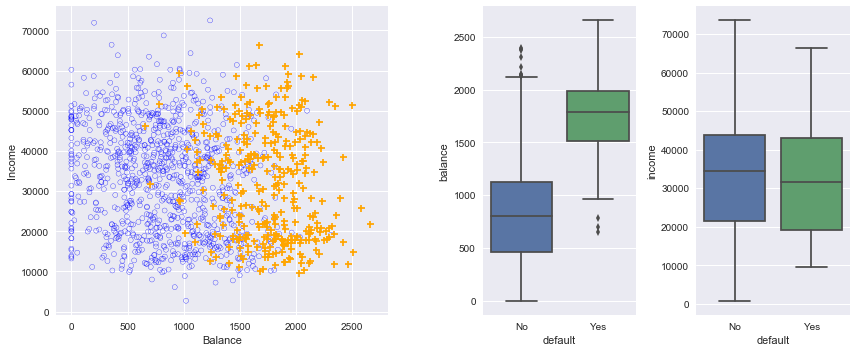

In [64]:
fig = plt.figure(figsize=(12, 5))

#this will create axes in which the left plot spans 2 columns 
#and the right two span only 1 column
ax1 = plt.subplot(121)
ax2 = plt.subplot(143)
ax3 = plt.subplot(144)

#take 1000 samples where the individual did not default
default_no_sample = default[default['default'] == 'No'].sample(n=1000)
ax1.scatter(default_no_sample['balance'].values,
            default_no_sample['income'].values,
            marker='o', edgecolors='blue', facecolors='None', s=25)
#include all samples where the individual did default
ax1.scatter(default[default['default'] == 'Yes']['balance'].values,
            default[default['default'] == 'Yes']['income'].values,
            marker='+', color='orange')
ax1.set(xlabel='Balance', ylabel='Income')

sns.boxplot(x=default['default'], y=default['balance'], ax=ax2)

sns.boxplot(x=default['default'], y=default['income'], ax=ax3)

fig.tight_layout()

# Why Not Linear Regression
Suppose we are trying to predict the medical condition of a patient in the emergency room on the basis of symptoms. If there are three possible diagnoses (stroke, drug overdose, or epileptic seizure), $Y$ would be coded as a quantitative response as follows:  

$$Y = \begin{cases}
1 & \text{if }\textbf{stroke}\\
2 & \text{if }\textbf{drug overdose}\\
3 & \text{if }\textbf{epileptic seizure}
\end{cases}$$  

Using this coding, least squares could be used to fit a linear regression to $Y$ on the basis of a set of predictors $X_1, ..., X_p$. Unfortunately, this coding implies an ordering of the outcomes, putting drug overdose in between stroke and epileptic seizuresm and insisting that the difference between stroke and drug overdose is the same as the difference between drug overdose and epileptic seizure. In practice however, there is no particular ordering to the response, so it can also be coded:  

$$Y = \begin{cases}
1 & \text{if }\textbf{epileptic seizure}\\
2 & \text{if }\textbf{stroke}\\
3 & \text{if }\textbf{drug overdose}
\end{cases}$$  

which would imply a completely different relationship among the three conditions in linear regression and thus a totally different prediction on test observations.  

If the response did take on a natural ordering, such as *mild*, *moderate*, and *severe*, and we felt that the gap between mild and moderate was similar to the gap between moderate and severe, then the 1, 2, 3 coding would be reasonable. Unfortunately, in general there is no natural way to convert a qualitative response variable with more than two levels into a quantitative response that is ready for linear regression modelling.  

The situation is better for a *binary* (two level) qualitative rsponse. For instance, perhaps there are only two possibilities for the patients medical condition: stroke or drug overdose. We could potentially use the *dummy variable* approach to code $Y$ as:  

$$Y = \begin{cases}
0 & \text{if }\textbf{stroke}\\
1 & \text{if }\textbf{drug overdose}
\end{cases}$$  

and simply predict drug overdose if $\widehat{Y} > 0.5$ and stroke otherwise. If we flipped the above coding, linear regression will produce the same results.  

Although in a binary response it can be shown that $X\widehat{\beta}$ is in fact an estimate of PR(drug overdose | $X$), some of our estimates might be outside the [0, 1] interval, making them hard to interpret as probabilities. Nevertheless, the predictions provide an ordering and can be interpreted as crude probability estimates.  

However, the dummy variable approach cannot be easily extended to accomodate qualitative responses with more than two levels. For these reasons, it's preferable to use a classification methot that is truly suited for qualitative response values.  

# Logistic Regression
Consider the default data set again, where the response falls into one of two categories, Yes or No. Rather than modeling this response directly, logistic regression models the *probability* that $Y$ belongs to a particular category.  For example the probability of default give balance can be written as  

$$\text{Pr}(default = \text{Yes} | balance)$$  

The values of $\text{Pr}(default = \text{Yes} | balance)$, which we abbreviate $p(balance)$, will range between 0 and 1. Then for any given value of balance, a prediction can be made for default. For example, one might predict $default = $Yes for any individual for whom $p(balance) > 0.5$. Alternatively, if a company wishes to be conservative in predicting individuals who are at risk, it may choose a lower threshold such as $p(balance) > 0.1$.  

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


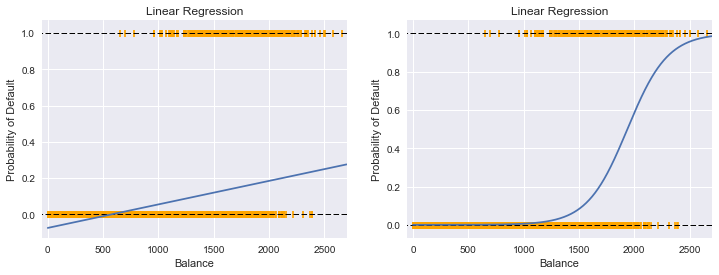

In [108]:
#figure 4.2

#create dummy variables for default and student
default2 = pd.get_dummies(default, drop_first=True)
#create linear regression and logit regression models
default_ols = smf.ols('default_Yes ~ balance', default2).fit()
default_logit = smf.logit('default_Yes ~ balance', default2).fit()
#create x variable for predictions
x = np.linspace(0, 2700, 1000)
#make predictions for each model
default_ols_pred = default_ols.predict(exog={'balance': x});
default_logit_pred = default_logit.predict(exog={'balance': x});
#create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
#left panel
ax1.scatter(default2['balance'], default2['default_Yes'], marker='|', color='orange')
ax1.hlines(0, -100, 3000, linestyles='dashed', lw=1)
ax1.hlines(1, -100, 3000, linestyles='dashed', lw=1)
ax1.set(xlim=[min(x)-50, max(x)], xlabel='Balance', ylabel='Probability of Default',
        title='Linear Regression');
#this plots the linear regression line
ax1.plot(x, default_ols_pred);
#right panel
ax2.scatter(default2['balance'], default2['default_Yes'], marker='|', color='orange')
ax2.hlines(0, -100, 3000, linestyles='dashed', lw=1)
ax2.hlines(1, -100, 3000, linestyles='dashed', lw=1)
ax2.set(xlim=[min(x)-50, max(x)], xlabel='Balance', ylabel='Probability of Default',
        title='Linear Regression');
#this plots the logistic regression line
ax2.plot(x, default_logit_pred);

## The Logistic Model
In the left panel of the figure above we see the problem with using linear regression in a classification setting. Specifically, for values of balance close to zero, we predict a negative probabily of default while at very high values for balance, we will predict a probability greater than 1. These are not sensible predictions since the tru probability must fall between 0 and 1.  

To avoid this problem, we must model $p(X)$ using a function that gives outputs between 0 and 1 for all values of $X$. Many functions meet this description. In logistic regression we use the *logistic function*  

$$p(X) = \frac{e^{\beta_0 + \beta_1X}}{1 + e^{\beta_0 + \beta_1X}}$$  

To fit this model, we use a method called *maximum likelihood*. In the right panel of the above plot we have modeled the response with a logistic regression. Notice that for values of balance close to zero, we predict the probability of default as close to but never below zero. Likewise for high balances we predict a default probability close to but never greater than 1. So regardless of $X$ we will obtain a sensible prediction. The logistic regression is also better able to capture the range of probabilities than the linear regression model.  

After a bit of minipulation, we find that  

$$\frac{p(X)}{1 - p(X)} = e^{\beta_0 + \beta_1X}$$  

which is called the *odds*. Odds can take on any value between 0 and $\infty$, which indicate very low and very high probabilities respectively. For example, on average 1 in 5 people with an odds of $\frac{1}{4}$ will default (since $p(X) = 0.2$ implies an odds of $\frac{0.2}{1 - 0.2} = \frac{1}{4}$). Likewise an average 9 in 10 people with an odds of 9 will default (since $p(X) = 0.9$ implies an odds of $\frac{0.9}{1 - 0.9} = 9$). Odds are traditionally used in horse-racing, since they relate more naturally to the correct betting strategy.  

By taking the logorithm of both sides we get  

$$log\biggl(\frac{p(X)}{1 - p(X)}\biggr) = \beta_0 + \beta_1X$$  

The left-hand side is called the *log-odds* or *logit*. We see that the logistic regression model has a logit that is linear in $X$ space.  

Recall that in linear regression, the coefficient $\beta_1$ gives the average change in $Y$ due to a one-unit increase in $X$. In logistic regression, increasing $X$ by one unit changes the **log odds** by $\beta_1$ (or equivalently, it multiplies the odds by $e^{\beta_1}$). However, because the relationship between $p(X)$ and $X$ is not a straight line, $\beta_1$ does not correspond to the change in $p(X)$ associated with a one-unit increas in $X$. Instead, it can be interpreted that if $\beta_1$ is positive, then increasing $X$ will be associated with increasing $p(X)$ and vice versa.  

## Estimating the Regression Coefficients  
Although we could use (non-linear) least squares to fit the model and find the coefficients $\beta_0$ and $\beta_1$, the more general method of *maximum likelihood* is preferred, since it has better statistical properties. The basic intuition is: we seek estimates for $\beta_0$ and $\beta_1$ such that the predicted probability $\widehat{p}(x_i)$ of default for each individual corresponds as closely as possible to the individuals observed status. In other words, we try to find $\widehat{\beta}_0$ and $\widehat{\beta}_1$ such that plugging these into the model for $p(X)$ yields a number close to one for all individuals who defualted, and a number close to zero for all individuals who did not. This can be formalized using a mathematical equation called a *likelihood function*:  

$$\ell(\beta_0, \beta_1) = \prod_{i:y_i=1}p(x_i)\prod_{i^\prime:y_{i^\prime}=0}(1-p(x_{i^\prime}))$$  

The estimates $\widehat{\beta}_0$ and $\widehat{\beta}_1$ are chosen to *maximize* this likelihood function.

In [109]:
#table 4.1
default_logit.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-10.6513,0.361,-29.491,0.000,-11.359,-9.943
balance,0.0055,0.000,24.952,0.000,0.005,0.006
